# GPU-Accelerated Data Science in Python

Workshop exploring methods for GPU-accelerated data science in the Python programming language.

Requirements:
- NVIDIA GPU
- Container runtime for [nvcr.io/nvidia/pytorch:25.03-py3](https://catalog.ngc.nvidia.com/orgs/nvidia/containers/pytorch)
    - with [jupyterlab_nvdashboard](https://github.com/rapidsai/jupyterlab-nvdashboard)
- Experience with Python
 
Outcomes:
- Explore GPU-accelerated Data Science Packages
- Understand when GPU acceleration makes sense
- Learn how to work with data that doesn't fit in GPU memory
- Learn how to across multiple GPUs

## Introduction
<hr>

GPU-accelerated data science involves using GPUs to perform data-intensive computations more quickly than traditional Central Processing Units (CPUs).
GPUs excel in tasks that involve large-scale parallel processing, making them ideal for machine learning, deep learning, data processing, and scientific computing.

This workshop is meant to be generally applicable who already use python for data science.
We'll be learning how to adapt CPU-based data-science methods to run on the GPU.

## Quickstart with K-means on the GPU
<hr>

If you only have a few minutes, this section will get you started with GPU-accelerated data science.
We'll be using the k-means algorithm as our example algorithm because the methods are relatively simple and it has been re-implemented in many different python packages.

If you've never use the k-means algorith before, it partitions data into `k` clusters by minimizing the variance within each cluster.
The algorithm starts by initializing `k` centroids randomly.
Each data point is then assigned to the nearest centroid.
The centroids are updated to be the mean of the assigned points.
This process is repeated until convergence, where assignments no longer change.
The algorithm aims to find cluster centers that minimize intra-cluster distances.

### Starting from scratch

Lets say you wrote a python script like [kmeans.py](kmeans.py), which implements the k-means algorithm using numpy operations.
Take a look at the script to see what it's doing, but no need to master the content.

You'll notice that it focuses on minimizing for loops by using array-based operations.
This is necessary for performance in python since loops cannot be vectorized.

Since the script is in the same directory as this notebook, we can import it and run it as follows:

In [1]:
from kmeans import k_means
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Create some data
data = np.array([[1, 2], [1.5, 1.8], [5, 8], [8, 8], [1, 0.6], [99, 100]])
k = 3  # Number of clusters

# Run K-means
assignments, centroids = k_means(data, k)

# Print the results (you can modify this for your needs)
print("Final Centroids:\n", centroids)
print("Cluster Assignments:", assignments)

Final Centroids:
 [[ 99.         100.        ]
 [  6.5          8.        ]
 [  1.16666667   1.46666667]]
Cluster Assignments: [2 2 1 1 2 0]


### Generating large data

This numpy implementation works great for our current data.
What happens if data grows though?

To answer this question, we can create a function to generate large quantities of clustered data to see how this runs as data scales.

In [2]:
def generate_data(k=3, n=10, d=2, cmin=0, cmax=10):
    '''
    Generate a random dataset for clustering.
    k - number of clusters
    n - number of data points
    d - dimension of data points
    cmin - smallest centroid value
    cmax - largest centroid value
    '''
    # Generate random integers for centroids
    C = np.random.randint(cmin, cmax, size=(k,d))
    # Create data points by adding random noise to centroids
    D = np.random.randn(n, d)+C[np.random.choice(k, n, replace=True)]
    return D, C

data, centroids = generate_data(k=3, n=15, d=2)
print(centroids)
print(data)

[[5 2]
 [4 7]
 [6 8]]
[[5.89678115 8.4105985 ]
 [6.14404357 9.45427351]
 [5.76103773 2.12167502]
 [6.44386323 8.33367433]
 [5.49407907 6.79484174]
 [5.3130677  1.14590426]
 [1.44701018 7.6536186 ]
 [6.8644362  7.25783498]
 [7.26975462 0.54563433]
 [5.04575852 1.81281615]
 [7.53277921 9.46935877]
 [5.15494743 2.37816252]
 [4.11221425 0.01920353]
 [4.65208785 2.15634897]
 [6.23029068 3.20237985]]


### Plotting 2D clusters

To help understand the data that is generated, we can visualize it.
So we don't have to cover how to use [Matplotlib](https://matplotlib.org/) in this workshop, the [extras.py](extras.py) script contains a `plot_clusters` function for plotting 2D data.

Feel free to regernate data if the clusters don't make sense.

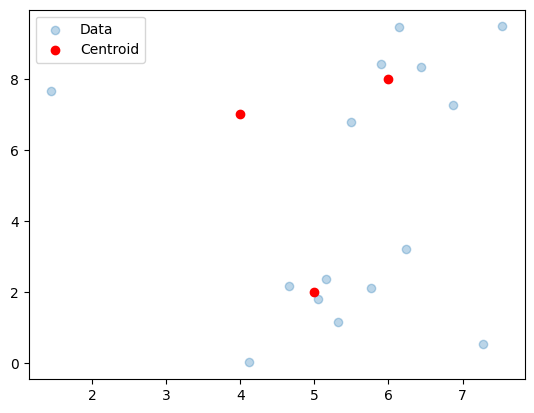

In [3]:
from extras import plot_clusters

plot_clusters(data, centroids=centroids)

### Running K-means

Try running the numpy implementation of K-means using the `k_means` function and visualize the cluster assignments using `plot_clusters` again.

In [4]:
assignments, calc_centroids = k_means(data, k=3)
print(calc_centroids)

[[6.39599707 8.28676364]
 [1.44701018 7.6536186 ]
 [5.44239485 1.67276558]]


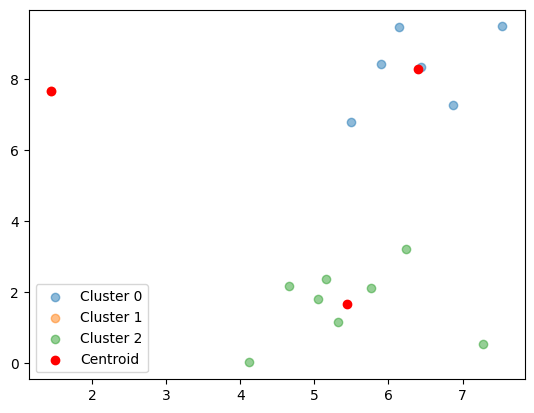

In [5]:
plot_clusters(data, assignments, k=3, centroids=calc_centroids)

This is mostly to prove we can now generate clusters of data in any shape.
I'm focusing on the centroids here so we don't have to get into assignment accuracy.
As the number of data points increases, the calculated centroids should get closer to actual.
Feel free to take some time to try increasing `n` when `generate_data` is called to verify this.

In [6]:
# Experiment with different counts and dimensions of data

# data, centroids = generate_data(k=3, n=20, d=3)

### Timing numpy implementation

Now, lets look at runtime as the data grows from 10 to 10,000,000 (10^7) data points.

Notice that we're only running K-means for a single iteration.
This is because it's an NP-hard algorithm with a non-deterministic runtime, so the runtime of the single iteration will give us an idea of how fast all steps will run.

In [7]:
k, d = 4, 4

for N in [10**power for power in range(1,8)]:
    data, real_centroids = generate_data(k=k, n=N, d=d, cmin=0, cmax=100)
    start_time = time()
    # Time a single iteration because k-means is non-deterministic
    k_means(data, k, max_iterations=1)
    elapsed_time = time()-start_time
    print(f"Finished kmeans on {N} points in {np.round(elapsed_time,4)} seconds")
    del data, real_centroids
print("Done") # I sometimes wait for another step

Finished kmeans on 10 points in 0.0004 seconds
Finished kmeans on 100 points in 0.0008 seconds
Finished kmeans on 1000 points in 0.0007 seconds
Finished kmeans on 10000 points in 0.0051 seconds
Finished kmeans on 100000 points in 0.0527 seconds
Finished kmeans on 1000000 points in 0.5055 seconds
Finished kmeans on 10000000 points in 5.2183 seconds
Done


### Timing Scikit-learn implementation

You may already know this, but the k-means algorithm and may others already exist in a package called [scikit-learn](https://scikit-learn.org/stable/), an open-source, widely-used Python package for machine learning. It provides a comprehensive set of algorithms for classification, regression, clustering, dimensionality reduction, and more, along with tools for model selection, data preprocessing, and visualization.

<img src="https://raw.githubusercontent.com/scikit-learn/scikit-learn/refs/heads/main/doc/logos/scikit-learn-logo.png" alt="scikit" style="margin: 0 auto;" />

The k-mean class exists in the "cluster" collection.
Take a look at the documentation to learn how to use it.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [8]:
from sklearn.cluster import KMeans

k, d = 4, 4

for N in [10**power for power in range(1,8)]:
    data, real_centroids = generate_data(k=k, n=N, d=d, cmin=0, cmax=100)
    start_time = time()
    assignments = KMeans(n_clusters=k, random_state=0, max_iter=1).fit_predict(data)
    elapsed_time = time()-start_time
    print(f"Finished sklearn-kmeans on {N} points in {np.round(elapsed_time,4)} seconds")
    del data, real_centroids
print("Done")

Finished sklearn-kmeans on 10 points in 1.3336 seconds
Finished sklearn-kmeans on 100 points in 0.0025 seconds
Finished sklearn-kmeans on 1000 points in 0.0047 seconds
Finished sklearn-kmeans on 10000 points in 0.1515 seconds
Finished sklearn-kmeans on 100000 points in 0.1695 seconds
Finished sklearn-kmeans on 1000000 points in 0.4598 seconds
Finished sklearn-kmeans on 10000000 points in 3.7448 seconds
Done


You'll notice that for small cases, our numpy implementation is faster.
However, as data grows, the scikit-learn implmentation becomes faster.
If you open up a view of the CPU utilization, you'll notice that scikit-learn algorithms can use multiple CPU cores.

#### Exercise:
- Use `top` to look at CPU utilization while running KMeans

### Timing cuML Implementation

We've spent a lot of time on CPU code, but this workshop is meant to showcase GPU acceleration.

<img src="https://raw.githubusercontent.com/rapidsai/rapids.ai/refs/heads/main/assets/images/RAPIDS-logo.png" alt="rapids" style="margin: 0 auto; width: 50%;" />
<br>

[RAPIDS](https://rapids.ai) provides unmatched speed with familiar APIs that match the most popular PyData libraries. Built on state-of-the-art foundations like NVIDIA CUDA and Apache Arrow, it unlocks the speed of GPUs with code you already know.

<html>
<table><thead>
  <tr>
    <th></th>
    <th><b>CPU</b></th>
    <th bgcolor="#7400ff" style="color:white;"><b>RAPIDS - GPU</b></th>
  </tr></thead>
<tbody>
  <tr>
    <td>Pandas</td>
    <td><pre>import pandas as pd<br>df = pd.read_csv("filepath")</pre></td>
    <td><pre>import cudf<br>df = cudf.read_csv("filepath")</pre></td>
  </tr>
  <tr>
    <td>Spark</td>
    <td><pre>spark.sql("""<br>select<br>    order<br>    count(*) as order_count<br>from<br>    orders""")</pre></td>
    <td><pre>spark.conf.set("spark.plugins",<br>"com.nvidia.spark.SQLPlugin")<br>spark.sql("""<br>select<br>    order<br>    count(*) as order_count<br>from<br>    orders""")</pre></td>
  </tr>
  <tr>
    <td>scikit-learn</td>
    <td><pre>from sklearn.ensemble import RandomForestClassifier<br>clf = RandomForestClassifier()<br>clf.fit(x,y)</pre></td>
    <td><pre>from cuml.ensemble import RandomForestClassifier<br>clf = RandomForestClassifier()<br>clf.fit(x,y)</pre></td>
  </tr>
  <tr>
    <td>NetworkX</td>
    <td><pre>import networkx as nx<br>page_rank = nx.pagerank(graph)</pre></td>
    <td><pre>import cugraph<br>page_rank = cugraph.pagerank(graph)</pre></td>
  </tr>
</tbody></table>
</html>

Based on this, there should be a [cuml.cluster.KMeans](https://docs.rapids.ai/api/cuml/stable/api/#k-means-clustering)

> The documentation also states that this function can be imported with either `cuml.KMeans` and `cuml.cluster.KMeans`

In [9]:
# https://docs.rapids.ai/api/cuml/stable/api/#k-means-clustering
from cuml.cluster import KMeans

k, d = 4, 4

for N in [10**power for power in range(1,8)]:
    data, real_centroids = generate_data(k=k, n=N, d=d, cmin=0, cmax=100)
    start_time = time()
    assignments = KMeans(n_clusters=k, random_state=0, max_iter=1, n_init='auto').fit_predict(data)
    elapsed_time = time()-start_time
    print(f"Finished cuml-kmeans on {N} points in {np.round(elapsed_time,4)} seconds")
    del data, real_centroids
print("Done")

Finished cuml-kmeans on 10 points in 0.6309 seconds
Finished cuml-kmeans on 100 points in 0.0056 seconds
Finished cuml-kmeans on 1000 points in 0.0053 seconds
Finished cuml-kmeans on 10000 points in 0.0092 seconds
Finished cuml-kmeans on 100000 points in 0.0496 seconds
Finished cuml-kmeans on 1000000 points in 0.3724 seconds
Finished cuml-kmeans on 10000000 points in 2.2638 seconds
Done


### Precision

While GPU performance is faster than multi-core CPU, it could be faster.
By default, numpy creates arrays in FP64 precision.
This is great for numerical precision, but unless you're on a \[VAHB\]100 GPU with FP64 cores, performance will be limited.

As shown in the table below ([source](https://www.exxactcorp.com/blog/components/NVIDIA-L40S-GPU-Compared-to-A100-and-H100-Tensor-Core-GPU)), only high end data center cards have FP64 cores.
If you do process FP64 data, the program won't error out, but performance will be sub-optimal.

|                      | A100 80GB SXM | NVIDIA L40S  | H100 80 GB SXM |
|----------------------|---------------|--------------|----------------|
| GPU Architecture     | NVIDIA Ampere | Ada Lovelace | Hopper         |
| GPU Memory           | 80GB HBM2e    | 48GB GDDR6   | 80GB HBM3      |
| GPU Memory Bandwidth | 2039 GB/s     | 864 GB/s     | 3352 GB/s      |
| L2 Cache             | 40MB          | 96MB         | 50MB           |
| FP64                 | 9.7 TFLOPS    | N/A          | 33.5 TFLOPS    |
| FP32                 | 19.5 TFLOPS   | 91.6 TFLOPS  | 66.9 TFLOPS    |

The easiest way to change this is by casting the data to FP32 or lower.
You've probably done this in PyTorch with BF16 or "mixed-precision" settings, but this is what's happening on the back end.

In [10]:
# https://docs.rapids.ai/api/cuml/stable/api/#k-means-clustering
from cuml.cluster import KMeans

k, d = 4, 4

for N in [10**power for power in range(1,8)]:
    data, real_centroids = generate_data(k=k, n=N, d=d, cmin=0, cmax=100)
    
    # Cast the data to FP32
    data = data.astype(np.float32)
    
    start_time = time()
    assignments = KMeans(n_clusters=k, random_state=0, max_iter=1, n_init='auto').fit_predict(data)
    elapsed_time = time()-start_time
    print(f"Finished cuml-kmeans on {N} points in {np.round(elapsed_time,4)} seconds")
    del data, real_centroids
print("Done")

Finished cuml-kmeans on 10 points in 0.1717 seconds
Finished cuml-kmeans on 100 points in 0.0058 seconds
Finished cuml-kmeans on 1000 points in 0.0039 seconds
Finished cuml-kmeans on 10000 points in 0.0043 seconds
Finished cuml-kmeans on 100000 points in 0.01 seconds
Finished cuml-kmeans on 1000000 points in 0.0515 seconds
Finished cuml-kmeans on 10000000 points in 0.6129 seconds
Done


In my tests on a T4, I'm seeing a 2x speedup - all from chaning a single import!

### K-means Exercises:

- Try plotting timing differences
  - At what data scales is each method best?
- Try increasing the data dimension or count
  - Do any methods eventually fail?
- Try modifying `generate_data` to create [cupy arrays](https://docs.cupy.dev/en/stable/user_guide/basic.html)
  - Does this make the cuML method faster?
- Try different levels of precision
  - Is there a speed up on the CPU side as well?

## cuml.accel: Zero Code Change

Starting in RAPIDS 25.02.01, cuML can now automatically accelerate code that uses Scikit-Learn, UMAP-Learn, and HDBSCAN.
Simply change your invocation to include `-m cuml.accel` and the cuML libraries will be imported instead to run on NVIDIA GPUs and falling back to CPU when necessary.
Give it a try with our kmeans code using [sklearn_kmeans.py](sklearn_kmeans.py):

In [11]:
# scikit-learn scripts can also be converted directly
!python -m cuml.accel sklearn_kmeans.py

Finished sklearn-kmeans on 10 points in 1.4521 seconds
Finished sklearn-kmeans on 100 points in 0.0068 seconds
Finished sklearn-kmeans on 1000 points in 0.0071 seconds
Finished sklearn-kmeans on 10000 points in 0.0103 seconds
Finished sklearn-kmeans on 100000 points in 0.0541 seconds
Finished sklearn-kmeans on 1000000 points in 0.3796 seconds
Finished sklearn-kmeans on 10000000 points in 2.2457 seconds
Done


## CuPy: Accelerating NumPy

Similar to RAPIDS, [CuPy](https://cupy.dev/) provides a NumPy-compatible interface for GPU-accelerated computing.
CuPy leverages CUDA for parallel processing, making it ideal for applications requiring large-scale data processing and complex mathematical computations.

Going full-circle, go back and open our [kmeans.py](kmeans.py) file again.
You'll notice that the timing code we've been running is in the `__main__` portion of the script, so it will run with a normal `python kmeans.py` invocation.
We're also only using numpy and built-in python modules.
Since CuPy is meant to replace NumPy, we should be able to just change the import, and see what works...

Make that change and try running the script.

In [12]:
# After changing the import
!python kmeans.py

Finished kmeans on 10 points in 0.0005 seconds
Finished kmeans on 100 points in 0.0004 seconds
Finished kmeans on 1000 points in 0.0009 seconds
Finished kmeans on 10000 points in 0.0063 seconds
Finished kmeans on 100000 points in 0.0517 seconds
Finished kmeans on 1000000 points in 0.5088 seconds
Finished kmeans on 10000000 points in 5.2811 seconds
Done


If all went well, you should see a good speedup!

### Exercise:

- Look through code of your own to see where CuPy would be useful